<a href="https://colab.research.google.com/github/lukasoares/Model_to_predict_stroke/blob/main/Notebook_2_Preprocessamento_e_construcao_do_modelo/%20Modelagem_DataStroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Iniciando o Spark no Google Colab:

In [1]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("DataStrokeWithPysparkSQL") \
    .getOrCreate()

##Importando as bibliotecas que vão ser utilizadas

In [6]:
import numpy as np
import plotly.express as px
from pyspark.ml.feature import VectorAssembler,OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import confusion_matrix

In [5]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.2 MB/s eta 0:00:00


##Importantdo a base de dados já tratada

In [7]:
data= spark.read.csv('/content/drive/MyDrive/base_de_dados/Stroke-data/Clean-Stroke-data.csv', header = True, inferSchema = True)
data.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.1|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

##Pré-processamento dos dados
Foi utilizado o 'StringIndexer', que renomeia as colunas, o 'OneHotEncoder', que vetoriza as variáveis, e o 'VectorAssembler', que coloca todos os vetores gerados em apenas um vetor. Todos esses métodos também fazem parte da biblioteca do PySpark.

In [9]:
def create_encoder(column_name):
    string_indexer = StringIndexer(inputCol= column_name, outputCol= column_name + "_encoded")
    encoder = OneHotEncoder(dropLast=False, inputCol= column_name + "_encoded", outputCol=column_name + "Vec")
    return string_indexer, encoder

stringIndexer_gender, encoder_gender = create_encoder("gender")
stringIndexer_married, encoder_married = create_encoder("ever_married")
stringIndexer_work, encoder_work = create_encoder("work_type")
stringIndexer_residence, encoder_residence = create_encoder("Residence_type")
stringIndexer_smoking, encoder_smoking = create_encoder("smoking_status")

In [10]:
colunas_entrada=['age','hypertension', 'heart_disease','avg_glucose_level','genderVec', 'bmi', 'ever_marriedVec','work_typeVec','Residence_typeVec','smoking_statusVec']
vetor_entrada = VectorAssembler(inputCols=colunas_entrada,outputCol='features')

In [11]:
sequencia_transformacoes=[stringIndexer_gender,stringIndexer_married,stringIndexer_work,stringIndexer_residence,stringIndexer_smoking,encoder_gender,encoder_married,encoder_work,encoder_residence,encoder_smoking,vetor_entrada]

In [12]:
pipeline = Pipeline(stages=sequencia_transformacoes)
pipelineModel = pipeline.fit(data)
model = pipelineModel.transform(data)

In [13]:
model.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+---------------+-------------+-----------------+-----------------+--------------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|gender_encoded|ever_married_encoded|work_type_encoded|Residence_type_encoded|smoking_status_encoded|    genderVec|ever_marriedVec| work_typeVec|Residence_typeVec|smoking_statusVec|            features|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+---------------+-------------+-----------------+-----------------+--------------

##Teste de correlação de Pearson

In [15]:
correlacao = Correlation.corr(model, 'features').collect()[0][0]

In [16]:
columns_list = ['age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'Male',
 "Female",
 "Other",
 'bmi',
 'ever_marriedYes',
 'ever_marriedNo',
 'work_typePrivate',
 'work_typeSelf-employed',
 'work_typeGovt_job',
 'work_typeChildren',
 'work_typeNever_worked',
 'Residence_typeUrban',
 'Residence_typeRural',
 'smoking_statusFormerlysmoked',
 'smoking_statusNever_smoked',
 'smoking_statusSmokes',
 'smoking_statusUnknown']

In [17]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns = columns_list, index = columns_list)
dataframe_correlacao

,age,hypertension,heart_disease,avg_glucose_level,Male,Female,Other,bmi,ever_marriedYes,ever_marriedNo,...,work_typeSelf-employed,work_typeGovt_job,work_typeChildren,work_typeNever_worked,Residence_typeUrban,Residence_typeRural,smoking_statusFormerlysmoked,smoking_statusNever_smoked,smoking_statusSmokes,smoking_statusUnknown
age,1.000000,0.276398,0.263796,0.238171,0.027924,-0.027623,-0.010659,0.324296,0.679125,-0.679125,...,0.327989,-0.634215,0.130013,-0.078653,0.014180,-0.014180,0.119307,-0.378231,0.236897,0.073133
hypertension,0.276398,1.000000,0.108306,0.174474,-0.021143,0.021275,-0.004597,0.158293,0.164243,-0.164243,...,0.115442,-0.129506,0.017685,-0.021608,-0.007913,0.007913,0.065063,-0.141501,0.058853,0.031240
heart_disease,0.263796,0.108306,1.000000,0.161857,-0.085617,0.085717,-0.003343,0.036916,0.114644,-0.114644,...,0.086760,-0.091634,0.001330,-0.015712,0.003092,-0.003092,-0.021856,-0.066731,0.066804,0.044049
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,-0.054902,0.054580,0.011489,0.166876,0.155068,-0.155068,...,0.062694,-0.102250,0.013845,-0.014675,-0.004946,0.004946,0.023885,-0.095131,0.068111,0.017646
Male,0.027924,-0.021143,-0.085617,-0.054902,1.000000,-0.999597,-0.016642,0.026642,0.030483,-0.030483,...,0.026143,-0.089120,0.016685,-0.011469,0.006340,-0.006340,0.099111,-0.059393,-0.043603,-0.011306
Female,-0.027623,0.021275,0.085717,0.054580,-0.999597,1.000000,-0.011757,-0.026310,-0.029936,0.029936,...,-0.025971,0.089283,-0.016534,0.011496,-0.005937,0.005937,-0.098813,0.059658,0.042738,0.011477
Other,-0.010659,-0.004597,-0.003343,0.011489,-0.016642,-0.011757,1.000000,-0.011743,-0.019327,0.019327,...,-0.006112,-0.005514,-0.005374,-0.000920,-0.014217,0.014217,-0.010728,-0.009206,0.030568,-0.005978
bmi,0.324296,0.158293,0.036916,0.166876,0.026642,-0.026310,-0.011743,1.000000,0.334911,-0.334911,...,0.070160,-0.442102,0.077856,-0.028327,-0.000277,0.000277,0.107636,-0.264915,0.103533,0.084392
ever_marriedYes,0.679125,0.164243,0.114644,0.155068,0.030483,-0.029936,-0.019327,0.334911,1.000000,-1.000000,...,0.192716,-0.544441,0.134041,-0.090838,0.006261,-0.006261,0.102845,-0.332081,0.171256,0.105226
ever_marriedNo,-0.679125,-0.164243,-0.114644,-0.155068,-0.030483,0.029936,0.019327,-0.334911,-1.000000,1.000000,...,-0.192716,0.544441,-0.134041,0.090838,-0.006261,0.006261,-0.102845,0.332081,-0.171256,-0.105226


Ao observar a matriz de correlação, pode-se perceber que não há nenhuma correlação forte entre as variáveis independentes, não sendo necessária a exclusão de nenhuma coluna.

<Axes: >

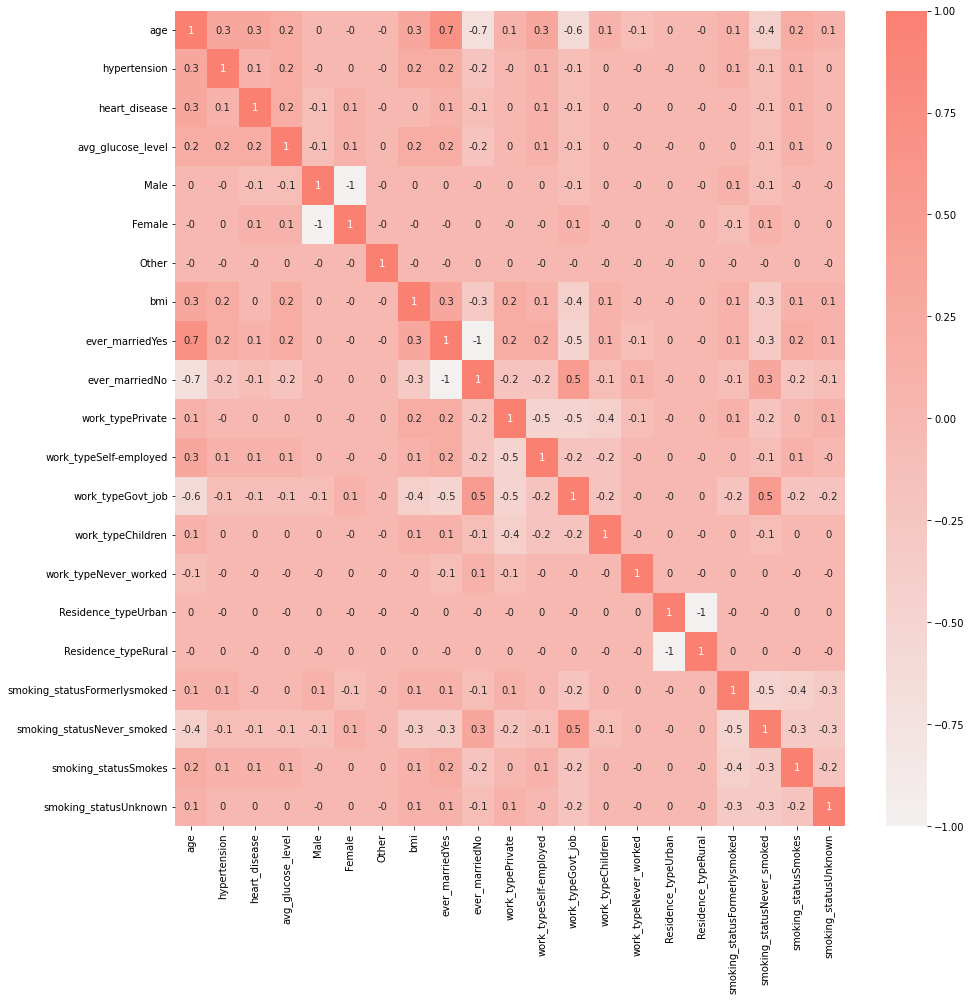

In [19]:
plt.figure(figsize=(15,15))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

#Divisão entre os datasets de treino e teste e aplicação do método smot
Primeiro, o banco de dados foi separado entre treino e teste utilizando o método 'sampleBy', que possibilita dividir o dataset distribuindo a coluna 'stroke' de forma proporcional entre a base de treino e teste.

Após a divisão, foi aplicado no conjunto de dados de treinamento 'train_data' o método 'SMOTE', que gera dados sintéticos para equilibrar a variável dependente 'stroke'.

In [20]:
train_data = model.sampleBy('stroke', fractions={0: 0.8, 1: 0.8}, seed=1)
test_data = model.subtract(train_data)


Contagem dos labels de stroke antes de usar "smote":

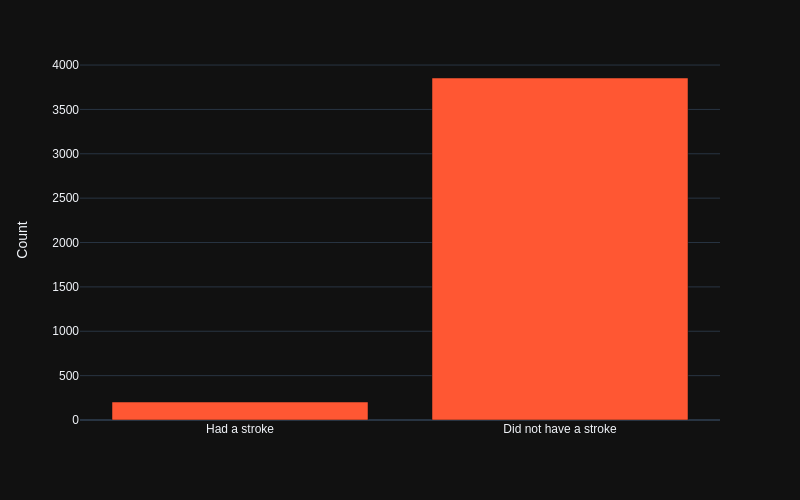

In [21]:
train_data.createOrReplaceTempView("trainView")
count_beforeSmote = spark.sql('select stroke, count(*) from trainView group by stroke').toPandas()
x = ["Had a stroke" , "Did not have a stroke"]
fig = px.bar(x = x, y = count_beforeSmote['count(1)'], width=800, height=500, color_discrete_sequence=['#FF5733'])
fig.update_layout(yaxis_title="Count", template="plotly_dark").update_layout(xaxis_title="")
fig.show('png')

In [22]:
X_train = train_data.select('features').rdd.flatMap(lambda x: x).collect()
X_train = np.array(X_train)
y_train = train_data.select('stroke').rdd.flatMap(lambda x: x).collect()
y_train = np.array(y_train)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

df_features = spark.createDataFrame(pd.DataFrame(X_train_resampled))
df_y = spark.createDataFrame(pd.DataFrame(y_train_resampled, columns=['stroke']))

assembler = VectorAssembler(inputCols = df_features.columns, outputCol = 'features')
df_features = assembler.transform(df_features).select('features')

train_smote = spark.createDataFrame(pd.concat([df_features.toPandas(), df_y.toPandas()], axis = 1))


Contagem dos labels de stroke depois de usar "smote":

In [23]:
train_smote.createOrReplaceTempView("smoteView")
count_smote = spark.sql('select stroke, count(*) from smoteView group by stroke').toPandas()

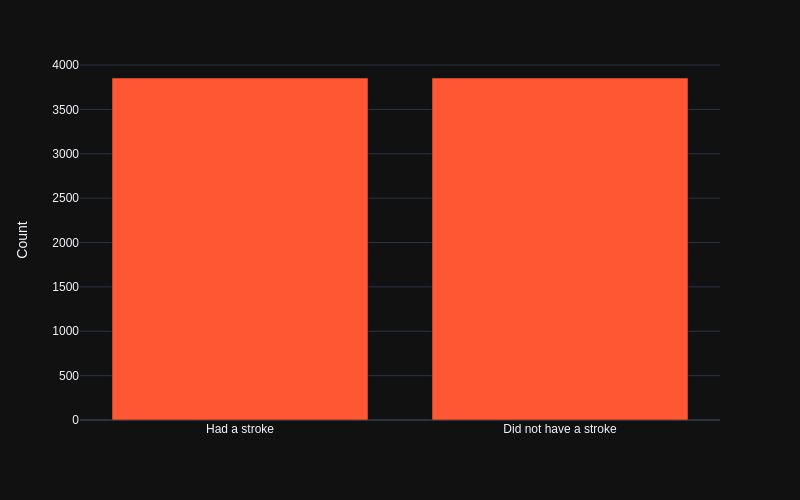

In [24]:
fig = px.bar(x = x, y = count_smote['count(1)'], width=800, height=500, color_discrete_sequence=['#FF5733'])
fig.update_layout(yaxis_title="Count", template="plotly_dark").update_layout(xaxis_title="")
fig.show('png')

In [ ]:
train_smote.show()

+--------------------+------+
|            features|stroke|
+--------------------+------+
|(21,[0,2,3,5,7,8,...|     1|
|(21,[0,3,4,7,8,11...|     1|
|(21,[0,2,3,5,7,8,...|     1|
|(21,[0,3,4,7,8,10...|     1|
|(21,[0,3,5,7,8,10...|     1|
|(21,[0,1,2,3,5,7,...|     1|
|(21,[0,3,4,7,9,10...|     1|
|(21,[0,3,4,7,8,10...|     1|
|(21,[0,3,4,7,8,10...|     1|
|(21,[0,1,3,4,7,8,...|     1|
|(21,[0,2,3,4,7,8,...|     1|
|(21,[0,3,4,7,8,10...|     1|
|(21,[0,2,3,5,7,8,...|     1|
|(21,[0,3,4,7,9,10...|     1|
|(21,[0,2,3,5,7,9,...|     1|
|(21,[0,3,4,7,8,13...|     1|
|(21,[0,1,3,4,7,8,...|     1|
|(21,[0,3,4,7,8,11...|     1|
|(21,[0,2,3,5,7,8,...|     1|
|(21,[0,3,5,7,8,10...|     1|
+--------------------+------+
only showing top 20 rows



In [ ]:
count_smote.stroke.values

array([0, 1])

#Otimização dos hyperparâmetros
Para testar qual seria o melhor modelo foram escolhidos o Logistic Regression, Random Florest Regression e o Gradient Boosted Trees, mas antes disso foi testado qual seria os melhores hyperparâmetros de cada modelo.
## Logistic Regression

Alguns algoritmos de machine learning são bastante sensíveis a scala das variáveis independentes. Para minimizar esse problema, foi utilizado o "StandardScaler" que padroniza os valores entre -1 e 1.

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
lr = LogisticRegression(labelCol="stroke",featuresCol="scaledFeatures")

In [ ]:
pipeline_lr = Pipeline(stages=[scaler, lr])

A métrica utilizada para avaliar o modelo foi o F1 Score, que é uma medida de média harmônica entre a precisão e a recall, que busca equilibrar a importância de ambas as medidas na avaliação do modelo. Assim, o F1 Score é uma métrica que busca avaliar a capacidade do modelo em equilibrar a identificação correta de ambas as classes, evitando o overfitting em alguma delas.

In [ ]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")

In [ ]:
param_grid_lr = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.01, 0.1, 1, 10])
              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
              .addGrid(lr.maxIter, [10, 50, 100])
              .addGrid(lr.tol, [1e-4, 1e-3, 1e-2])
              .build())

Foi criada a função "CrossValidatorTuning" para efetar o Cross Validation retornando o modelo já ajustado.

In [ ]:
def CrossValidatorTuning(pipeline, param_grid, evaluator):
    model = CrossValidator(estimator= pipeline,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=5)
    return model.fit(train_smote)

In [ ]:
cvModel_lr = CrossValidatorTuning(pipeline_lr, param_grid_lr, acc_evaluator)

Também foi criada a função "getBestParams" que retorma os valores dos melhores hyperpâmetros encontrados.

In [ ]:
def getBestParams(model):
  param_map = model.getEstimatorParamMaps()
  avg_metrics = model.avgMetrics
  best_index = np.argmax(avg_metrics)
  best_param_map = param_map[best_index]
  print(avg_metrics)
  return best_param_map 


In [ ]:
best_param_map_lr = getBestParams(cvModel_lr)
best_param_map_lr

##Random Florest Classifier

In [ ]:
rf = RandomForestClassifier(labelCol="stroke",featuresCol="scaledFeatures")

param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.impurity, ['entropy', 'gini']) \
    .build()

In [ ]:
pipeline_rf = Pipeline(stages=[scaler, rf])

In [ ]:
cvModel_rf = CrossValidatorTuning(pipeline_rf, param_grid_rf, acc_evaluator)

In [ ]:
best_param_map_rf = getBestParams(cvModel_rf)
best_param_map_rf

##LinearSVC

In [ ]:
svc= LinearSVC(labelCol="stroke",featuresCol="scaledFeatures")

In [ ]:
pipeline_svc = Pipeline(stages=[scaler, svc])

In [ ]:
param_grid_svc = (ParamGridBuilder()
    .addGrid(svc.regParam, [0.1, 0.01])
    .addGrid(svc.maxIter, [50, 100, 150, 200])
    .addGrid(svc.tol, [1e-3, 1e-4])
    .addGrid(svc.standardization, [True, False])
    .build())

In [ ]:
cvModel_svc = CrossValidatorTuning(pipeline_svc, param_grid_svc, acc_evaluator)

In [ ]:
best_param_map_svc = getBestParams(cvModel_svc)
best_param_map_svc

##GradientBoostedTrees

In [ ]:
gbt= GBTClassifier(labelCol="stroke",featuresCol="scaledFeatures")

In [ ]:
pipeline_gbt = Pipeline(stages=[scaler, gbt])

In [ ]:
param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 4, 6]) \
    .addGrid(gbt.maxBins, [20, 30, 40]) \
    .addGrid(gbt.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(gbt.stepSize, [0.01, 0.05, 0.1]) \
    .build()

In [ ]:
cvModel_gbt = CrossValidatorTuning(pipeline_gbt, param_grid_gbt, acc_evaluator)

In [ ]:
best_param_map_gbt = getBestParams(cvModel_gbt)
best_param_map_gbt

##Avaliando os modelos com o dataset de teste com matriz de confusão

Primeiramente foi preciso padronizar os dados, pois não foi utilizado Pipeline nesse momento.

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(train_data)
scaled_train_smote= scalerModel.transform(train_smote)
scaled_teste = scalerModel.transform(test_data)

Foi criada a função "getF1Andmatriz" que imprime o F1 Score do modelo e retorna a matriz de confusão que foi gerada utilizando o "confusion matrix" do Scikit-Learn.

In [ ]:
def getF1Andmatriz(fit_model):

  prediction = fit_model.transform(scaled_teste)

  accuracy = acc_evaluator.evaluate(prediction)
  print(f"F1 Score: {accuracy}")

  confusion_matrix_result = confusion_matrix(test_data.select('stroke').toPandas(), prediction.select('prediction').toPandas())

  return pd.DataFrame(confusion_matrix_result, columns = ['Prediction_0', 'Prediction_1'], index = ['Real_0', 'Real_1'])


In [ ]:
model_lr = LogisticRegression(labelCol="stroke", featuresCol="scaledFeatures", regParam = 0.01, elasticNetParam = 0.0, maxIter = 50, tol = 0.0001)
model_lr_fit = model_lr.fit(scaled_train_smote)
getF1Andmatriz(model_lr_fit)

F1 Score: 0.8224687225570592


,Prediction_0,Prediction_1
Real_0,750,257
Real_1,8,38


In [ ]:
model_rf = RandomForestClassifier(labelCol="stroke", featuresCol="scaledFeatures", numTrees=30, maxDepth=15, impurity='entropy')
model_rf_fit = model_rf.fit(scaled_train_smote)

getF1Andmatriz(model_rf_fit)


F1 Score: 0.9382337714533391


,Prediction_0,Prediction_1
Real_0,1001,6
Real_1,43,3


In [ ]:
model_svc = LinearSVC(labelCol="stroke",featuresCol="scaledFeatures", regParam = 0.01, maxIter = 50, tol = 0.0001, standardization = True)
model_svc_fit = model_svc.fit(scaled_train_smote)

getF1Andmatriz(model_svc_fit)

F1 Score: 0.8093421415634284


,Prediction_0,Prediction_1
Real_0,728,279
Real_1,6,40


In [ ]:
model_gbt= GBTClassifier(labelCol="stroke",featuresCol="scaledFeatures", maxDepth = 6, maxBins = 20, minInstancesPerNode  = 10, stepSize = 0.1)
model_gbt_fit = model_gbt.fit(scaled_train_smote)

getF1Andmatriz(model_gbt_fit)

F1 Score: 0.935386184157079


,Prediction_0,Prediction_1
Real_0,987,20
Real_1,40,6


De fato, ao avaliar modelos de classificação binária para prever a ocorrência de AVC, é importante levar em consideração a métrica que melhor reflete o objetivo do modelo. Nesse caso, como o foco é identificar corretamente os casos positivos (pessoas que tiveram AVC), a métrica de maior importância é a sensibilidade, que indica a proporção de casos positivos corretamente identificados pelo modelo.

Analisando as matrizes de confusão e o F1 Score dos modelos avaliados, observa-se que Random Forest e Gradient Boost apresentaram melhor desempenho global, porém tiveram baixa sensibilidade para o label 1, ou seja, erraram muito ao prever as pessoas que tiveram AVC, com apenas 2/46 e 6/46 casos corretamente identificados, respectivamente.

Por outro lado, Logistic Regression e SVC apresentaram acurácia global menor, mas tiveram sensibilidade significativamente maior para o label 1, com 38/46 e 40/46 casos corretamente identificados, respectivamente. Além disso, esses modelos tiveram uma boa acurácia para prever os casos negativos (pessoas que não tiveram AVC).

Portanto, considerando o objetivo de identificar corretamente os casos positivos, os modelos Logistic Regression e SVC são mais adequados para essa tarefa do que Random Forest e Gradient Boost.

Numericamente não há grande diferança entre Logistic Regression e SVC e ambos obtiveram uma média de F1 Score parecida usando o Cross Validation, mas SVC se saiu melhor na sensibilididade para o label 1 e por isso foi o modelo escolhido. 

In [ ]:
coeficientes = model_svc_fit.coefficients

In [ ]:
coeficientes_lr = model_lr_fit.coefficients

##Análise dos coeficientes dos melhores modelos

In [ ]:
pd.DataFrame(coeficientes, index = columns_list, columns = ['Coeficientes']).sort_values(by= 'Coeficientes', ascending= False)

,Coeficientes
age,1.332399
work_typeGovt_job,0.412933
avg_glucose_level,0.110027
heart_disease,0.105292
hypertension,0.094315
smoking_statusSmokes,0.081767
smoking_statusUnknown,0.048474
Female,0.043474
ever_marriedNo,0.043085
bmi,0.018697


In [ ]:
pd.DataFrame(coeficientes_lr, index = columns_list, columns = ['Coeficientes']).sort_values(by= 'Coeficientes', ascending= False)

,Coeficientes
age,1.569972
hypertension,0.178936
avg_glucose_level,0.158244
heart_disease,0.128936
smoking_statusSmokes,0.072041
work_typeGovt_job,0.070500
smoking_statusUnknown,0.051403
smoking_statusNever_smoked,0.041924
work_typePrivate,0.040303
Female,0.037883


Pode-se observar que os modelos apresentam similaridades em seus maiores coeficientes, sendo que a variável "age" é a que possui o maior peso em ambos. Além disso, as variáveis "hypertension", "avg_glucose_level" e "heart_disease" também apresentam uma forte influência em ambos os modelos.

Chama a atenção em ambos os modelos a variável "work_type_Govt_job", que mostra um grande peso na probabilidade da pessoa ter um AVC ou não. Isso sugere que ser um servidor público pode ser um fator importante na previsão do risco de AVC

#Conclusão
O modelo de classificação SVC (Support Vector Classification) apresentou a maior taxa de acerto na previsão de pessoas que tiveram AVC (86%), com um F1 Score global de 80%. No entanto, é importante lembrar que a base de dados original é bastante desbalanceada, o que pode ter afetado o desempenho do modelo. Assim, uma maior amostra de pessoas que tiveram AVC poderia ser útil para melhorar o desempenho do modelo.

Ao analisar os dois melhores modelos, observou-se que ambos deram grande peso às variáveis "age", "hypertension", "avg_glucose_level" e "heart_disease". Além disso, foi surpreendente notar que a variável "work_type_Govt_job" também apresentou grande influência na probabilidade da pessoa ter um AVC.

Por outro lado, é interessante notar a pouca influência da variável "bmi" na probabilidade da pessoa ter um AVC. Isso sugere que o índice de massa corporal pode não ser um fator tão importante para prever o risco de AVC em comparação com outras variáveis, como idade, hipertensão, nível médio de glicose e doença cardíaca.